In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
from sklearn.metrics import classification_report
import torch

In [3]:
# Load the pre-trained model and tokenizer
model_name = "./finetuned_wikineural"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [1]:
# Load preprocessed Italian dataset
from datasets import load_from_disk
italian_dataset = load_from_disk("Data_it/test_it")

In [2]:
print(italian_dataset[0])  # Print the first example
print(italian_dataset.features)  # Print the dataset features


{'tokens': ['Washington', 'Mystics'], 'ner_tags': [0, 0, 3, 4, 0, 0], 'langs': ['it', 'it', 'it', 'it', 'it', 'it'], 'spans': ['ORG: Washington Mystics'], 'input_ids': [101, 11586, 110760, 10107, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1], 'labels': [-100, 0, 0, -100, -100]}
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'spans': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), len

In [3]:
from collections import Counter

# Extrahiere die ner_tags aus dem Dataset
ner_tags = [tag for example in italian_dataset for tag in example["ner_tags"]]

# Mapping der numerischen Tags zu den Entity-Namen
tag_map = {
    0: "O",        # Outside any entity
    1: "B-PER",    # Beginning of a Person entity
    2: "I-PER",    # Inside a Person entity
    3: "B-ORG",    # Beginning of an Organization entity
    4: "I-ORG",    # Inside an Organization entity
    5: "B-LOC",    # Beginning of a Location entity
    6: "I-LOC"     # Inside a Location entity
}

# Konvertiere numerische Tags in lesbare Labels
ner_labels = [tag_map[tag] for tag in ner_tags]

# Zähle die Häufigkeiten der verschiedenen Tags
entity_counts = Counter(ner_labels)

In [4]:
# Relevante Entitäten filtern
filtered_counts = {
    entity: count for entity, count in entity_counts.items() if entity in ["B-PER", "B-ORG", "B-LOC"]
}

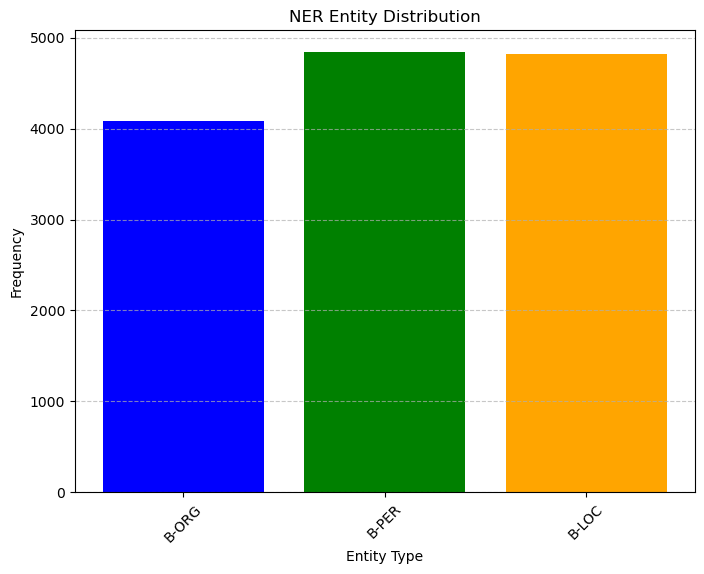

In [5]:
import matplotlib.pyplot as plt

# Daten für das Diagramm vorbereiten
entities = list(filtered_counts.keys())
counts = list(filtered_counts.values())

# Balkendiagramm erstellen
plt.figure(figsize=(8, 6))
plt.bar(entities, counts, color=["blue", "green", "orange"])
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.title("NER Entity Distribution")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [6]:
def prepare_dataset(examples):
    # The tokenization step is not needed as input_ids are already present
    return {
        'input_ids': examples['input_ids'],
        'attention_mask': examples['attention_mask'],
        'token_type_ids': examples['token_type_ids'],
        'labels': examples['labels']
    }

tokenized_italian = italian_dataset.map(prepare_dataset, batched=True)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
# Create a data loader:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
        'token_type_ids': torch.tensor([item['token_type_ids'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

data_loader = DataLoader(tokenized_italian, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [8]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    token_type_ids = [torch.tensor(item['token_type_ids']) for item in batch]
    labels = [torch.tensor(item['labels']) for item in batch]
    
    # Pad sequences to the maximum length in the batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    token_type_ids = pad_sequence(token_type_ids, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for padding in labels
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'labels': labels
    }

data_loader = DataLoader(tokenized_italian, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [9]:
from tqdm import tqdm
from seqeval.metrics import classification_report
import torch

model.eval()
all_predictions = []
all_true_labels = []

label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}

with torch.no_grad():
    for batch in tqdm(data_loader, desc="Evaluating"):
        # Überprüfe, ob alle Keys vorhanden sind
        assert 'input_ids' in batch and 'attention_mask' in batch and 'labels' in batch, \
            "Batch fehlt erforderliche Schlüssel!"

        # Inputs und Labels in das richtige Device laden
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(model.device)
        
        # Vorhersagen generieren
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)
        
        # Labels und Vorhersagen verarbeiten
        for pred, label, mask in zip(predictions, labels, batch['attention_mask']):
            pred = pred.cpu().numpy()
            label = label.cpu().numpy()
            mask = mask.cpu().numpy()

            # Filtern mit der attention_mask
            true_label = [label_map.get(l, 'O') for l, m in zip(label, mask) if m != 0]
            pred_label = [label_map.get(p, 'O') for p, m in zip(pred, mask) if m != 0]
            
            # Listenlänge angleichen (falls nötig)
            if len(true_label) != len(pred_label):
                min_len = min(len(true_label), len(pred_label))
                true_label = true_label[:min_len]
                pred_label = pred_label[:min_len]
            
            all_predictions.append(pred_label)
            all_true_labels.append(true_label)

# Klassifikationsbericht ausgeben
print(classification_report(all_true_labels, all_predictions))


Evaluating: 100%|██████████| 625/625 [01:16<00:00,  8.22it/s]


              precision    recall  f1-score   support

         LOC       0.18      0.19      0.19      4357
         ORG       0.17      0.16      0.17      5128
         PER       0.19      0.18      0.18      5094

   micro avg       0.18      0.18      0.18     14579
   macro avg       0.18      0.18      0.18     14579
weighted avg       0.18      0.18      0.18     14579

